In [1]:
import numpy as np
import pandas as pd
import scipy.optimize as optimize
import matplotlib
#matplotlib.use('TkAgg')
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
plt.rcParams["figure.figsize"] = (15,10)

In [ ]:
""" Optimization Algorithm """
""" New Matrix """
def newMat_2(x, Ut,Lt,Vt):
    l0,l1 = Lt[0], Lt[1]
    U_new = np.zeros((Ut.shape), dtype=np.cfloat)
    for i in range(Ut.shape[0]):
      U_new[i][0] = np.cos(x[i]) / l0
      U_new[i][1] = (np.sin(x[i]) / l1) * np.exp(1j*x[i+Ut.shape[0]])
    return np.dot(np.dot(U_new,np.diag(Lt)), Vt)


def newMat_3(x, Ut,Lt,Vt):
    l0,l1,l2 = Lt[0], Lt[1], Lt[2]
    U_new = np.zeros((Ut.shape), dtype=np.cfloat)
    for i in range(Ut.shape[0]):
      U_new[i][0] = np.cos(x[i]) / l0
      U_new[i][1] = (np.sin(x[i]) / l1) * (np.cos(x[i+Ut.shape[0]])) * np.exp(1j*x[i+2*Ut.shape[0]])
      U_new[i][2] = (np.sin(x[i]) / l2) * (np.sin(x[i+Ut.shape[0]])) * np.exp(1j*x[i+3*Ut.shape[0]])
    return np.dot(np.dot(U_new,np.diag(Lt)), Vt)


def newMat_4(x, Ut,Lt,Vt):
    l0,l1,l2,l3 = Lt[0], Lt[1], Lt[2], Lt[3]
    U_new = np.zeros((Ut.shape), dtype=np.cfloat)
    for i in range(Ut.shape[0]):
      U_new[i][0] = (np.cos(x[i]) / l0) * (np.cos(x[i+Ut.shape[0]]))
      U_new[i][1] = (np.cos(x[i]) / l1) * (np.sin(x[i+Ut.shape[0]])) * np.exp(1j*x[i+3*Ut.shape[0]])
      U_new[i][2] = (np.sin(x[i]) / l2) * (np.cos(x[i+2*Ut.shape[0]])) * np.exp(1j*x[i+4*Ut.shape[0]])
      U_new[i][3] = (np.sin(x[i]) / l3) * (np.sin(x[i+2*Ut.shape[0]])) * np.exp(1j*x[i+5*Ut.shape[0]])
    return np.dot(np.dot(U_new,np.diag(Lt)), Vt)

""" Cost Function """
def costFn(x, Ut,Lt,Vt,B,k):
    if k==2:
      Bp = newMat_2(x, Ut, Lt, Vt)
    elif k==3:
      Bp = newMat_3(x, Ut, Lt, Vt)
    elif k==4:
      Bp = newMat_4(x, Ut, Lt, Vt)
    else:
      return 0
    loss = np.linalg.norm(B**2 - np.abs(Bp)**2)
    return (loss)

In [ ]:
""" Calculating losses when k is in (2,3) and tol is in (1e-10, 1e-5, 1e-3)
a 3x3 matrix is used for experiment k=2 and tol in (1e-10, 1e-5, 1e-3)
a 4x4 matrix is used for the experiment k=3 and tol in (1e-10, 1e-5, 1e-3) """

res = np.zeros((2400,4))
count = 0
for k in [2,3,4]:
    print('\n')
    print("k = ", k)
    for i in range(100):
      if(i%10==0):
        print('\n')
        print(i, " ", end='')
      A = np.random.rand(k+1, k+1)
      for j in range(k+1): A[j] /= sum(A[j])
      B = np.sqrt(A)
      U, L, V = np.linalg.svd(B, full_matrices=False)
      initial_guess = np.ones((2*(k+1)*(k-1),), dtype=np.longdouble)
      Ut = U[:, :k]
      Vt = V[:k]
      Lt = L[:k]
      Bt = np.dot(np.dot(Ut,np.diag(Lt)), Vt)
      for tol in ([1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3]):
        if(i%10==0): print(tol, " ", end=' ')        
        result = optimize.minimize(fun=costFn, x0=initial_guess, args=(Ut,Lt,Vt,B,k),
                                            tol=tol, method='Nelder-Mead', options={'maxiter':1e+10})
        res[count][0] = k
        res[count][1] = tol
        res[count][2] = (np.linalg.norm(B**2 - Bt**2))
        res[count][3] = costFn(result.x,Ut,Lt,Vt,B,k)
        count+=1

In [2]:
#np.save('toltest_detail_2.npy',res)
res = np.load('toltest_detail_2.npy')
res

array([[2.00000000e+00, 1.00000000e-10, 3.80198052e-01, 2.51752487e-01],
       [2.00000000e+00, 1.00000000e-09, 3.80198052e-01, 2.51752487e-01],
       [2.00000000e+00, 1.00000000e-08, 3.80198052e-01, 2.51752487e-01],
       ...,
       [4.00000000e+00, 1.00000000e-05, 9.54130942e-03, 5.07100107e-03],
       [4.00000000e+00, 1.00000000e-04, 9.54130942e-03, 1.49142229e-02],
       [4.00000000e+00, 1.00000000e-03, 9.54130942e-03, 1.49241305e-02]])

In [3]:
df = pd.DataFrame(res, columns=['k', 'tol', 'loss1', 'loss2'])
df['RI'] = (df['loss1']-df['loss2'])/df['loss1']
df.head()

,k,tol,loss1,loss2,RI
0,2.0,1.000000e-10,0.380198,0.251752,0.337839
1,2.0,1.000000e-09,0.380198,0.251752,0.337839
2,2.0,1.000000e-08,0.380198,0.251752,0.337839
3,2.0,1.000000e-07,0.380198,0.251752,0.337839
4,2.0,1.000000e-06,0.380198,0.251752,0.337839


In [4]:
gdf = df.groupby(['k', 'tol']).mean()
gdf

loss1     loss2        RI
k   tol                                       
2.0 1.000000e-10  0.124278  0.085782  0.322729
    1.000000e-09  0.124278  0.085782  0.322729
    1.000000e-08  0.124278  0.085782  0.322729
    1.000000e-07  0.124278  0.085782  0.322729
    1.000000e-06  0.124278  0.085782  0.322726
    1.000000e-05  0.124278  0.085884  0.321681
    1.000000e-04  0.124278  0.085931  0.318369
    1.000000e-03  0.124278  0.086215  0.304712
3.0 1.000000e-10  0.067737  0.024480  0.532505
    1.000000e-09  0.067737  0.024481  0.532500
    1.000000e-08  0.067737  0.024697  0.531160
    1.000000e-07  0.067737  0.025662  0.511930
    1.000000e-06  0.067737  0.027239  0.487745
    1.000000e-05  0.067737  0.028408  0.453803
    1.000000e-04  0.067737  0.032178  0.399311
    1.000000e-03  0.067737  0.037167  0.185170
4.0 1.000000e-10  0.050423  0.014653 -1.808309
    1.000000e-09  0.050423  0.014653 -1.808309
    1.000000e-08  0.050423  0.014653 -1.808309
    1.000000e-07  0.050423  0.017150 -2.019344
    1.000000e-06  0.050423  0.020216 -3.198765
    1.000000e-05  0.050423  0.022377 -3.290430
    1.000000e-04  0.050423  0.027340 -3.702704
    1.000000e-03  0.050423  0.033714 -4.582293

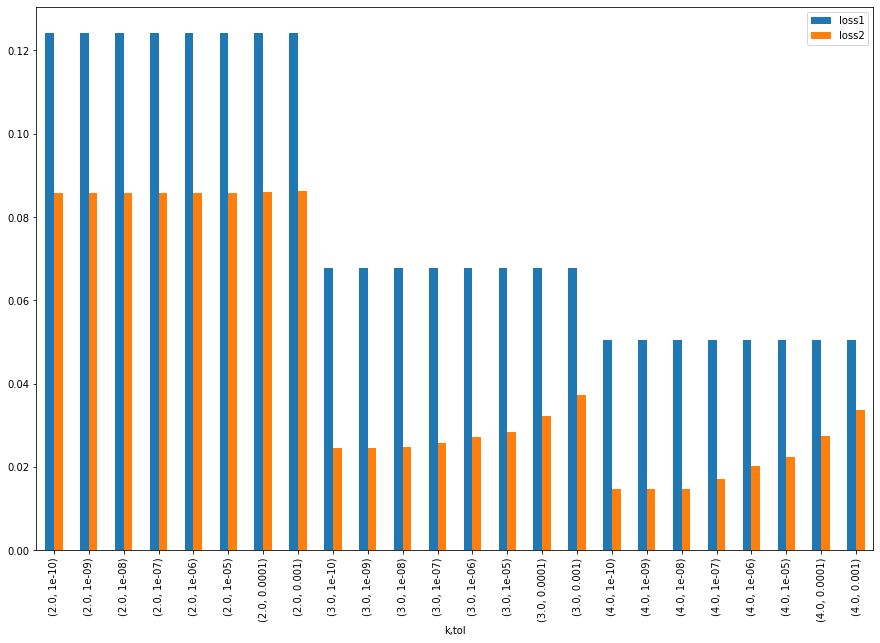

In [5]:
ax = gdf[['loss1','loss2']].plot(figsize=(15,10), kind='bar')
plt.show()

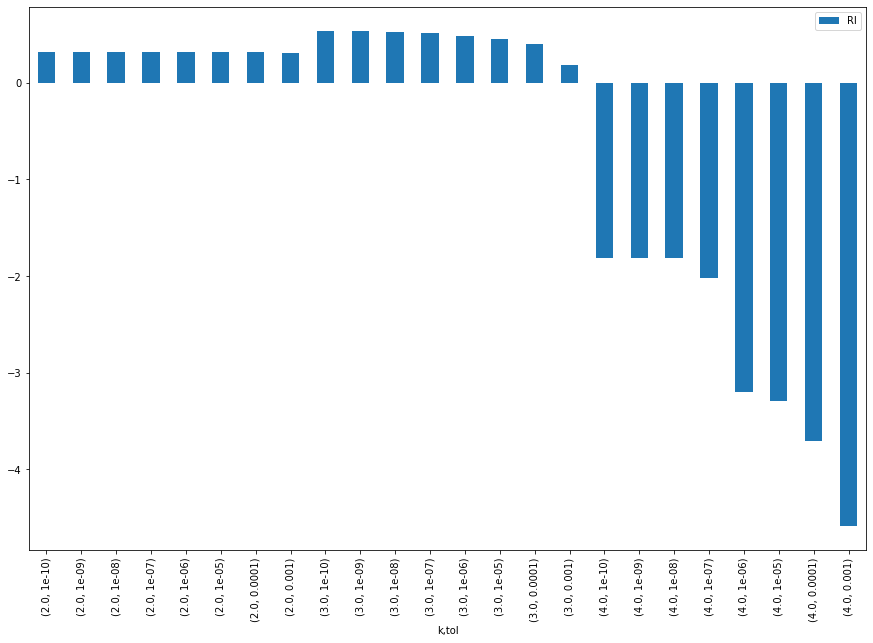

In [6]:
ax = gdf[['RI']].plot(figsize=(15,10), kind='bar')
plt.show()

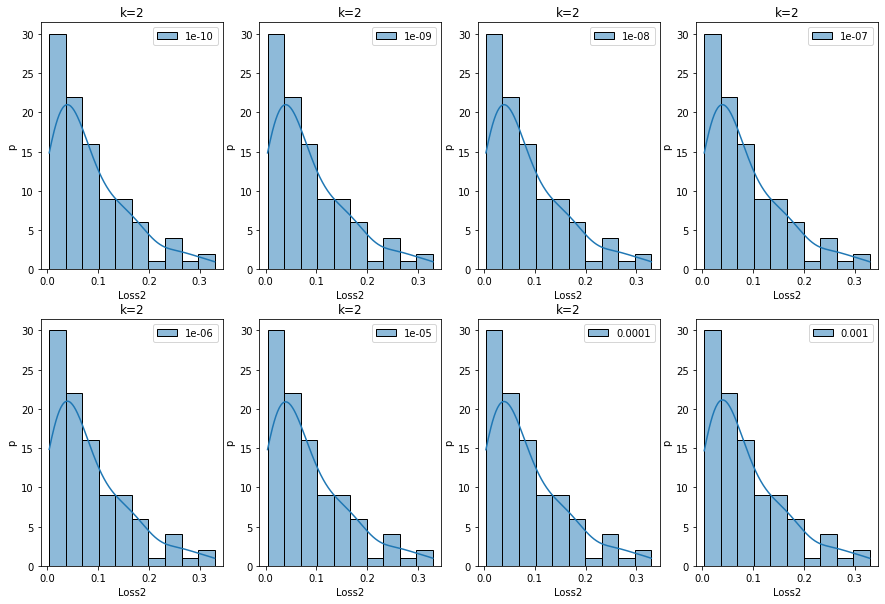

In [8]:
tollist = [1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
plt.figure(figsize=(15,10))
for i in range(8):
  plt.title("k=2")
  plt.subplot(2,4,i+1)
  sns.histplot(df.loc[(df.k==2) & (df.tol == tollist[i])]['loss2'], kde=True,label=str(tollist[i]), bins=10)
  plt.ylabel('p')
  plt.xlabel('Loss2')
  plt.legend()
plt.show()

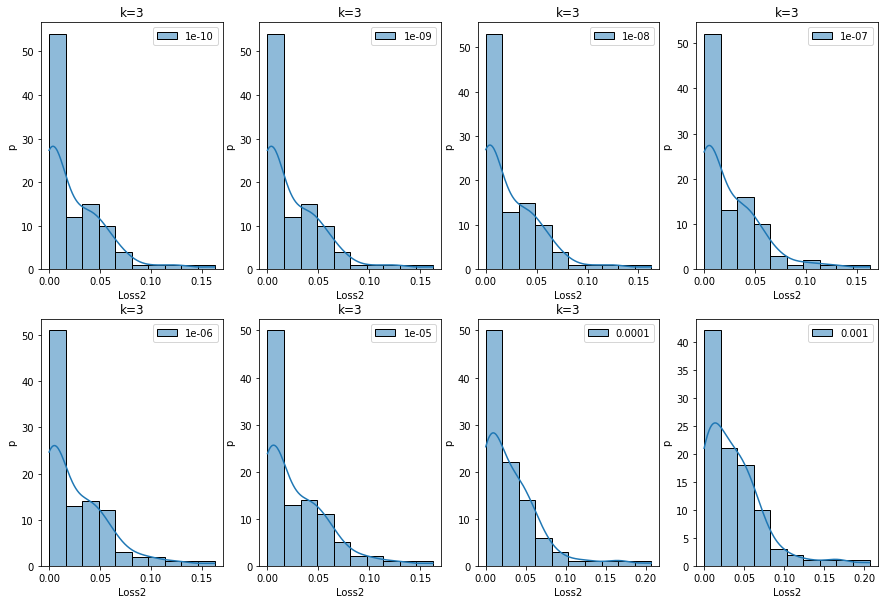

In [9]:
plt.figure(figsize=(15,10))
for i in range(8):
  plt.title("k=3")
  plt.subplot(2,4,i+1)
  sns.histplot(df.loc[(df.k==3) & (df.tol == tollist[i])]['loss2'], kde=True,label=str(tollist[i]), bins=10)
  plt.ylabel('p')
  plt.xlabel('Loss2')
  plt.legend()
plt.show()

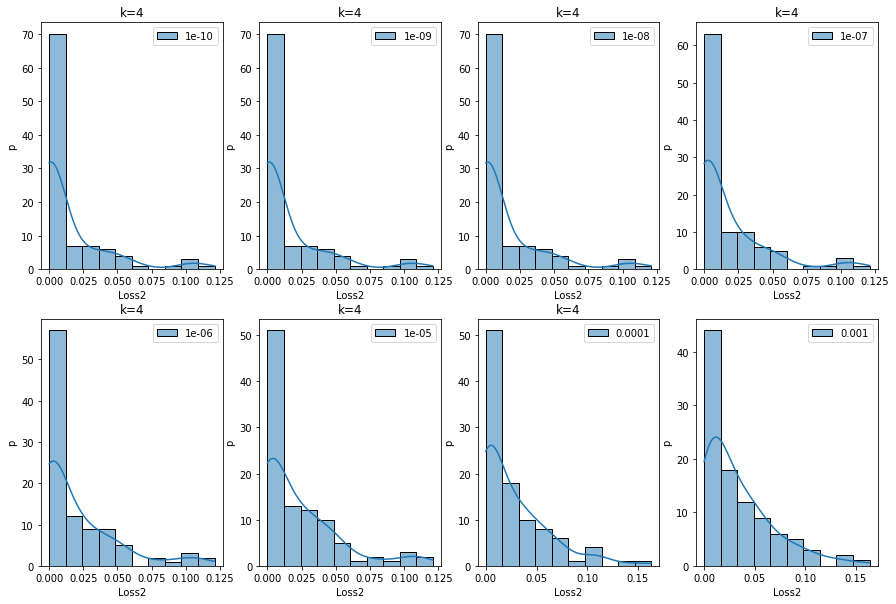

In [10]:
plt.figure(figsize=(15,10))
for i in range(8):
  plt.title("k=4")
  plt.subplot(2,4,i+1)
  sns.histplot(df.loc[(df.k==4) & (df.tol == tollist[i])]['loss2'], kde=True,label=str(tollist[i]), bins=10)
  plt.ylabel('p')
  plt.xlabel('Loss2')
  plt.legend()
plt.show()